In [31]:
# Import necessary libraries/modules
import vertica_python
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os

In [32]:
# Set up the Vertica Connection Information
username = os.getenv('VERTICA_USERNAME')
password = os.getenv('VERTICA_PASSWORD')

conn_info = {'host': 'warehouse.analytics.edx.org',
             'port': 5433,
             'user': username,
             'password': password,
             'database': 'warehouse',
             'read_timeout': 600,
             'unicode_error': 'strict',
             'ssl': False
            }

connection = vertica_python.connect(**conn_info)
cur = connection.cursor('dict')

In [33]:
query = """
SELECT
	a.course_id,
	SUM(CASE
			WHEN role = 'instructor' THEN 1 ELSE 0
		END) AS instructors,
	SUM(CASE
			WHEN role = 'staff' THEN 1 ELSE 0
		END) AS staff,
	sum_enrolls,
	sum_bookings
FROM
	lms_read_replica.student_courseaccessrole a
LEFT JOIN
	business_intelligence.course_stats_summary b
ON
	a.course_id = b.course_id
LEFT JOIN
	business_intelligence.course_master c
ON
	a.course_id = c.course_id
WHERE
	course_end_date <= CURRENT_DATE()
GROUP BY
	1, 4, 5;
"""

cur.execute(query)

df = pd.DataFrame(cur.fetchall())

6.0


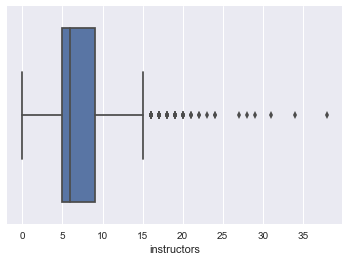

In [34]:
ax = sns.boxplot(x=df['instructors'])
print df['instructors'].median()

6.0


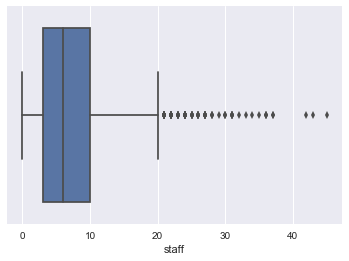

In [35]:
ax = sns.boxplot(x=df['staff'])
print df['staff'].median()

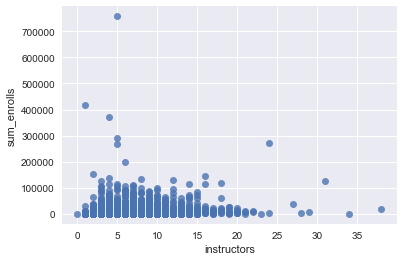

In [37]:
sns.regplot(x=df['instructors'], y=df['sum_enrolls'], fit_reg=False)

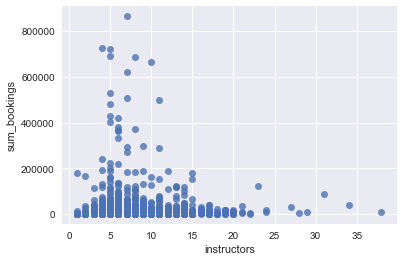

In [38]:
sns.regplot(x=df['instructors'], y=df['sum_bookings'], fit_reg=False)

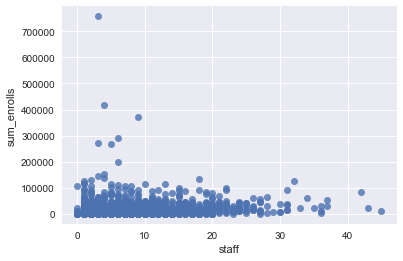

In [39]:
sns.regplot(x=df['staff'], y=df['sum_enrolls'], fit_reg=False)

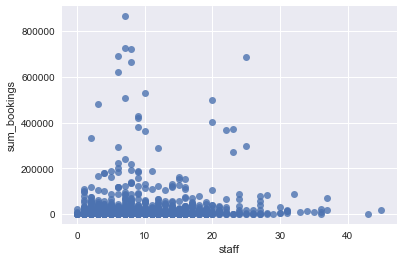

In [40]:
sns.regplot(x=df['staff'], y=df['sum_bookings'], fit_reg=False)

In [41]:
df['Staff Quartile'] = 'Null'

df['Staff Quartile'][df['staff'] >= df['staff'].quantile(.75)] = 'Q4'
df['Staff Quartile'][df['staff'] < df['staff'].quantile(.75)] = 'Q3'
df['Staff Quartile'][df['staff'] < df['staff'].quantile(.50)] = 'Q2'
df['Staff Quartile'][df['staff'] < df['staff'].quantile(.25)] = 'Q1'

C:\Users\ochang\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\ochang\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\ochang\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\ochang\AppData\Local\Continuum\Anaconda2\l

In [42]:
# Group by Quartiles to see Mean/Median of Enrollments for each Announcement Window Quartile
print df.groupby(['Staff Quartile'])['sum_enrolls'].mean()
print df.groupby(['Staff Quartile'])['sum_enrolls'].median()

print df.groupby(['Staff Quartile'])['staff'].mean()
print df.groupby(['Staff Quartile'])['staff'].median()

Staff Quartile
Q1     9350.404135
Q2    15151.640884
Q3    13704.636646
Q4    17766.853550
Name: sum_enrolls, dtype: float64
Staff Quartile
Q1     3913.0
Q2     6042.0
Q3     6784.5
Q4    10899.5
Name: sum_enrolls, dtype: float64
Staff Quartile
Q1     1.377820
Q2     3.996324
Q3     7.344186
Q4    15.235207
Name: staff, dtype: float64
Staff Quartile
Q1     1
Q2     4
Q3     7
Q4    14
Name: staff, dtype: int64


[(0, 60000)]

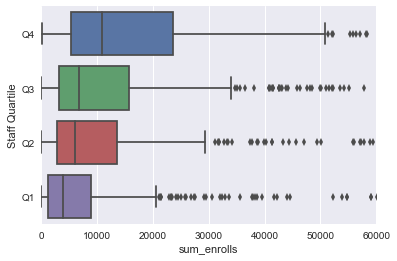

In [43]:
ax = sns.boxplot(x=df['sum_enrolls'], y=df['Staff Quartile'], order=['Q4', 'Q3', 'Q2', 'Q1'])
ax.set(xlim=(0, 60000))

In [47]:
from scipy.stats import ttest_ind

bottom_quartile = df[df['Staff Quartile'] == 'Q1']['sum_enrolls']
top_quartile = df[df['Staff Quartile'] == 'Q4']['sum_enrolls']

print (ttest_ind(bottom_quartile, top_quartile))

Ttest_indResult(statistic=-7.6900424573247879, pvalue=3.0394935983683035e-14)


In [30]:
# From a glance, this also looks significant - now we should dig into how many of those staff members were active?